In [ ]:
!pip install -e "git+https://github.com/daffarobani/smt-explainability.git"#egg=smt-ex
!pip install sobolsampling

In [1]:
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS

from smt_ex.shap.shap_display import ShapDisplay
from smt_ex.shap.shap_feature_importance_display import ShapFeatureImportanceDisplay

from sklearn.metrics import mean_squared_error

In [3]:
ndoe = 100
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8 * ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

## config
feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$', 
    r'$W_{dg}$', r'$W_{p}$',
]

class GroundTruthModel:
    def predict_values(self, X):
        return fun(X)
    
# kriging model
sm = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
sm.set_training_values(
    X_tr,
    y_tr
    )

sm.train()

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

# ground truth model
gtm = GroundTruthModel()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  8.3956621
Surrogate model
RMSE: 0.6717
rRMSE: 0.0025


In [4]:
instances = X_tr
model = sm

kernel_shap_explainer = ShapDisplay.from_surrogate_model(
    instances,
    model,
    X_tr, 
    feature_names=feature_names,
    method="kernel"
)

In [6]:
%%time
instances = X_tr
model = sm

exact_shap_explainer = ShapDisplay.from_surrogate_model(
    instances,
    model,
    X_tr, 
    feature_names=feature_names,
    method="exact"
)

CPU times: user 1min 51s, sys: 1min 35s, total: 3min 26s
Wall time: 28.2 s


CPU times: user 833 ms, sys: 50.3 ms, total: 883 ms
Wall time: 661 ms


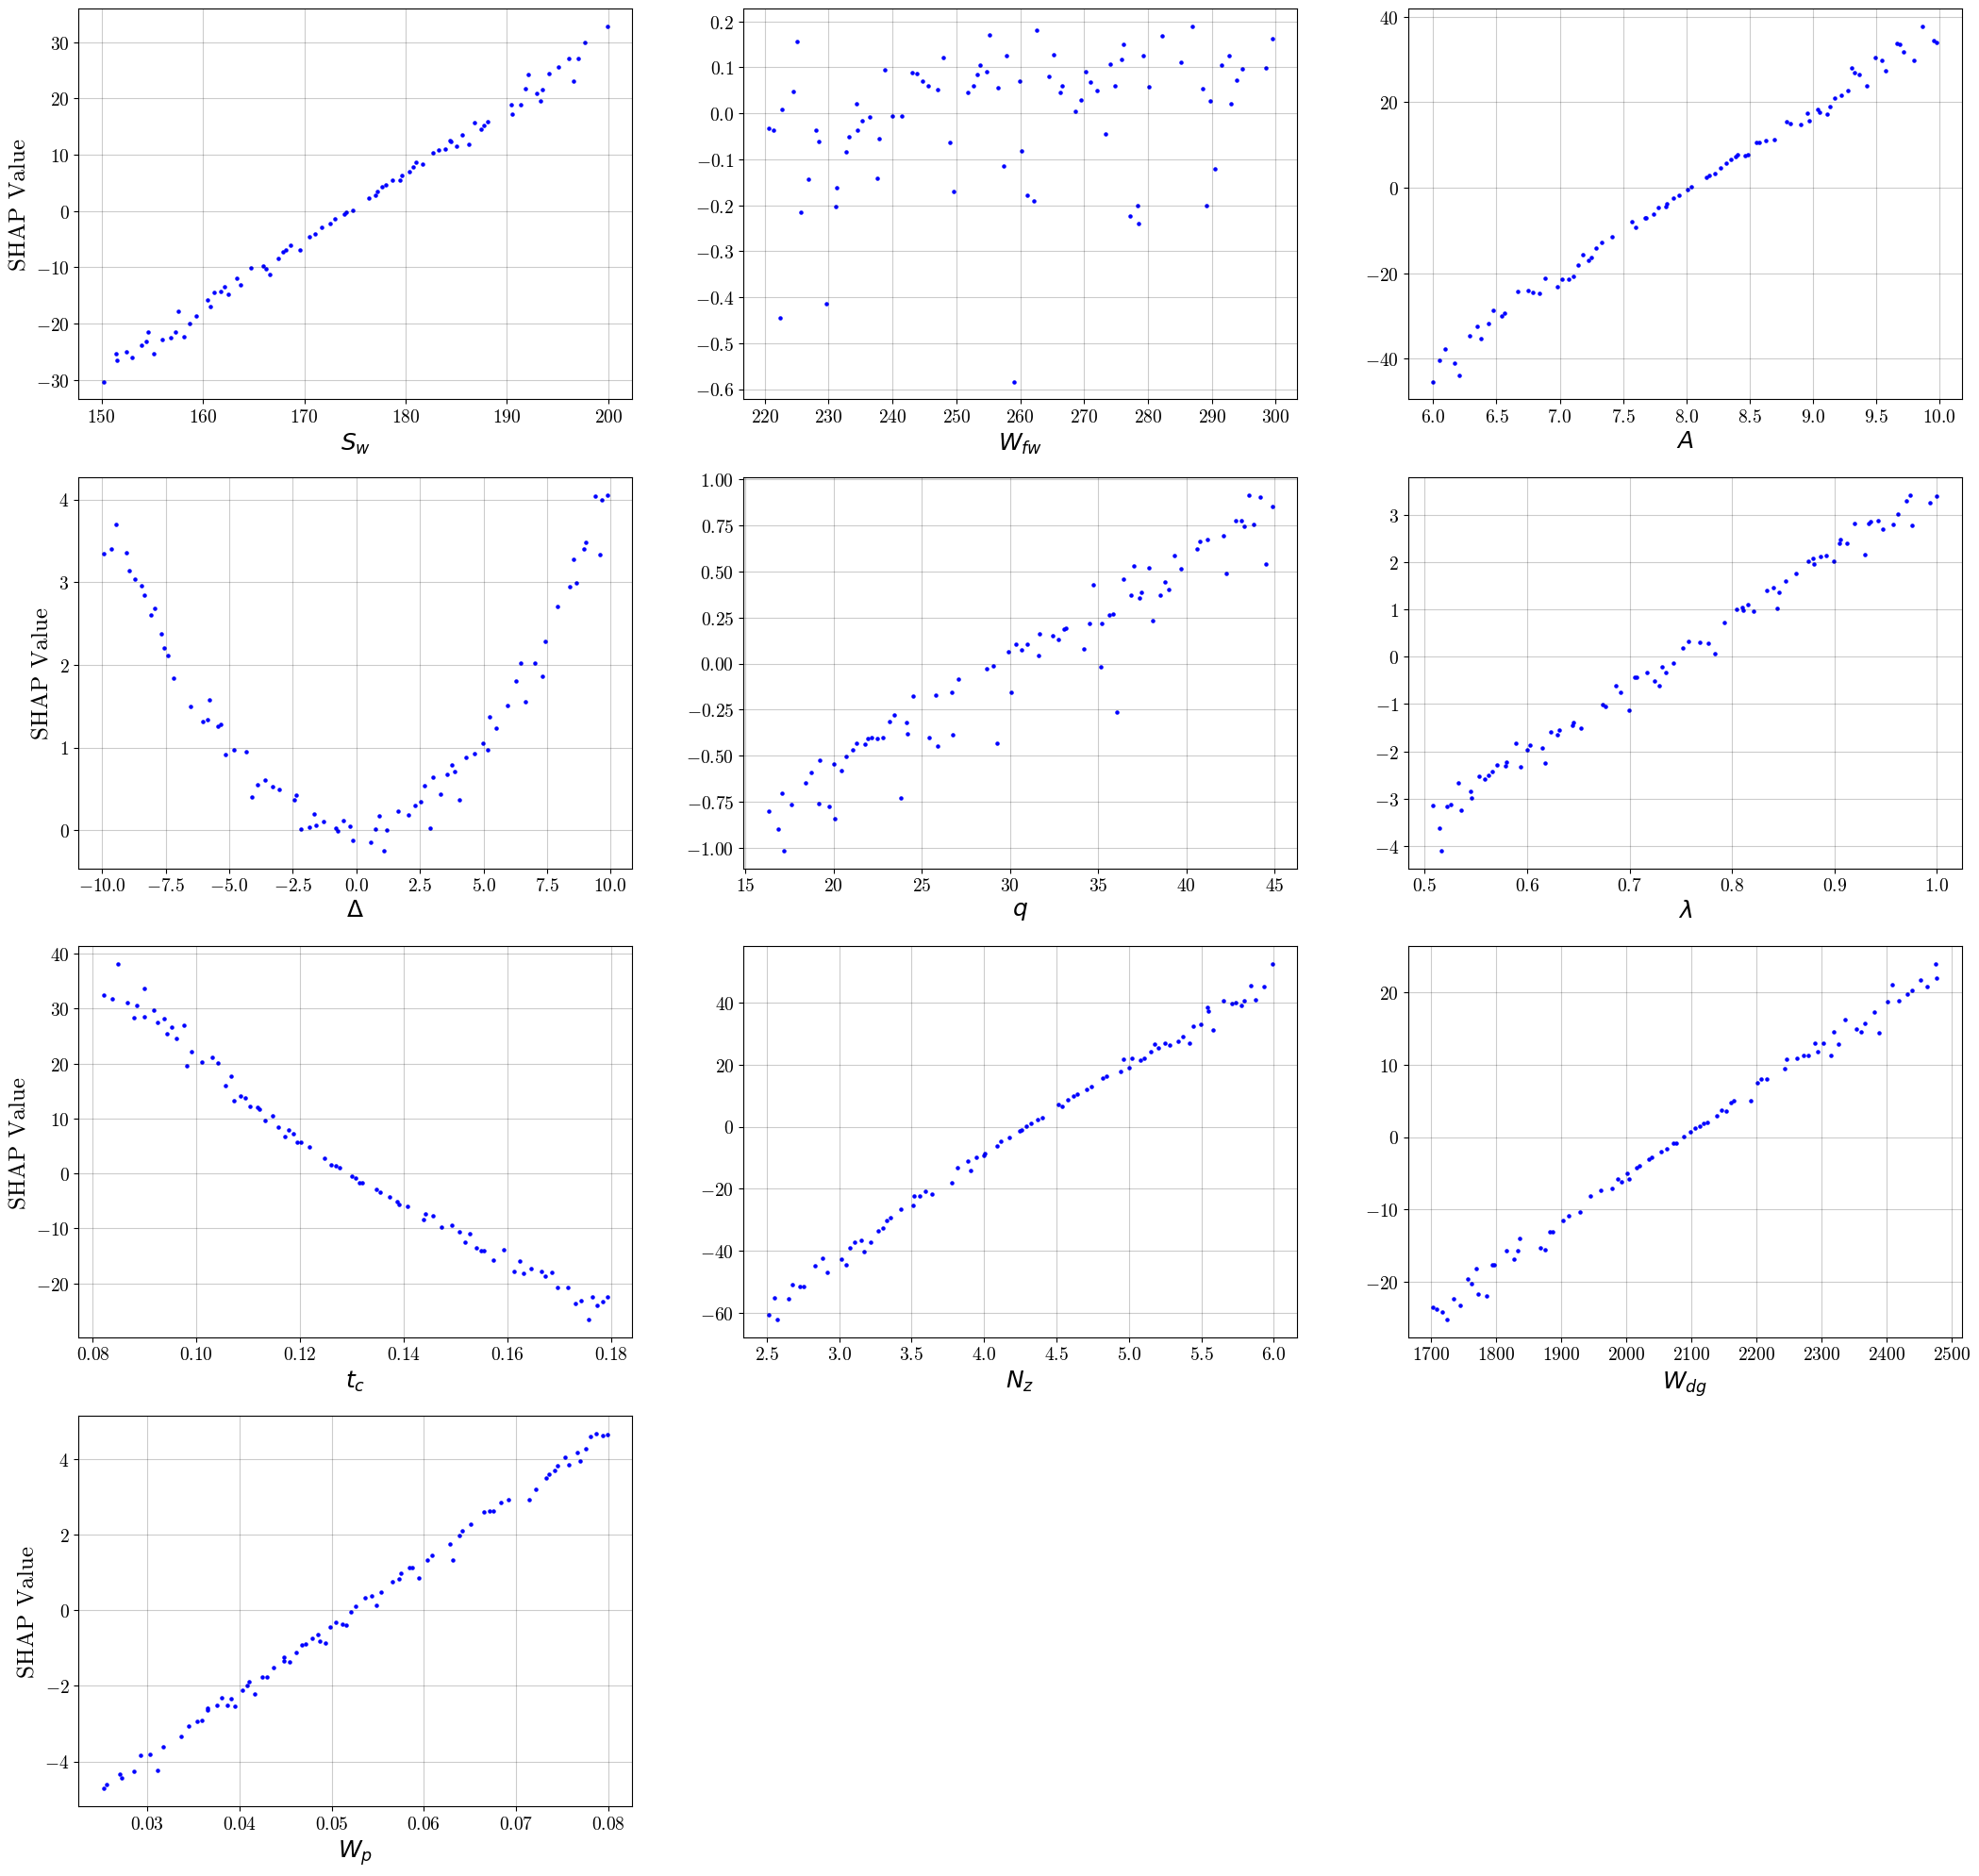

In [7]:
%%time
features = [i for i in range(X_tr.shape[1])]

kernel_shap_dependence = kernel_shap_explainer.dependence_plot(features)
kernel_shap_dependence

CPU times: user 663 ms, sys: 17.4 ms, total: 680 ms
Wall time: 285 ms


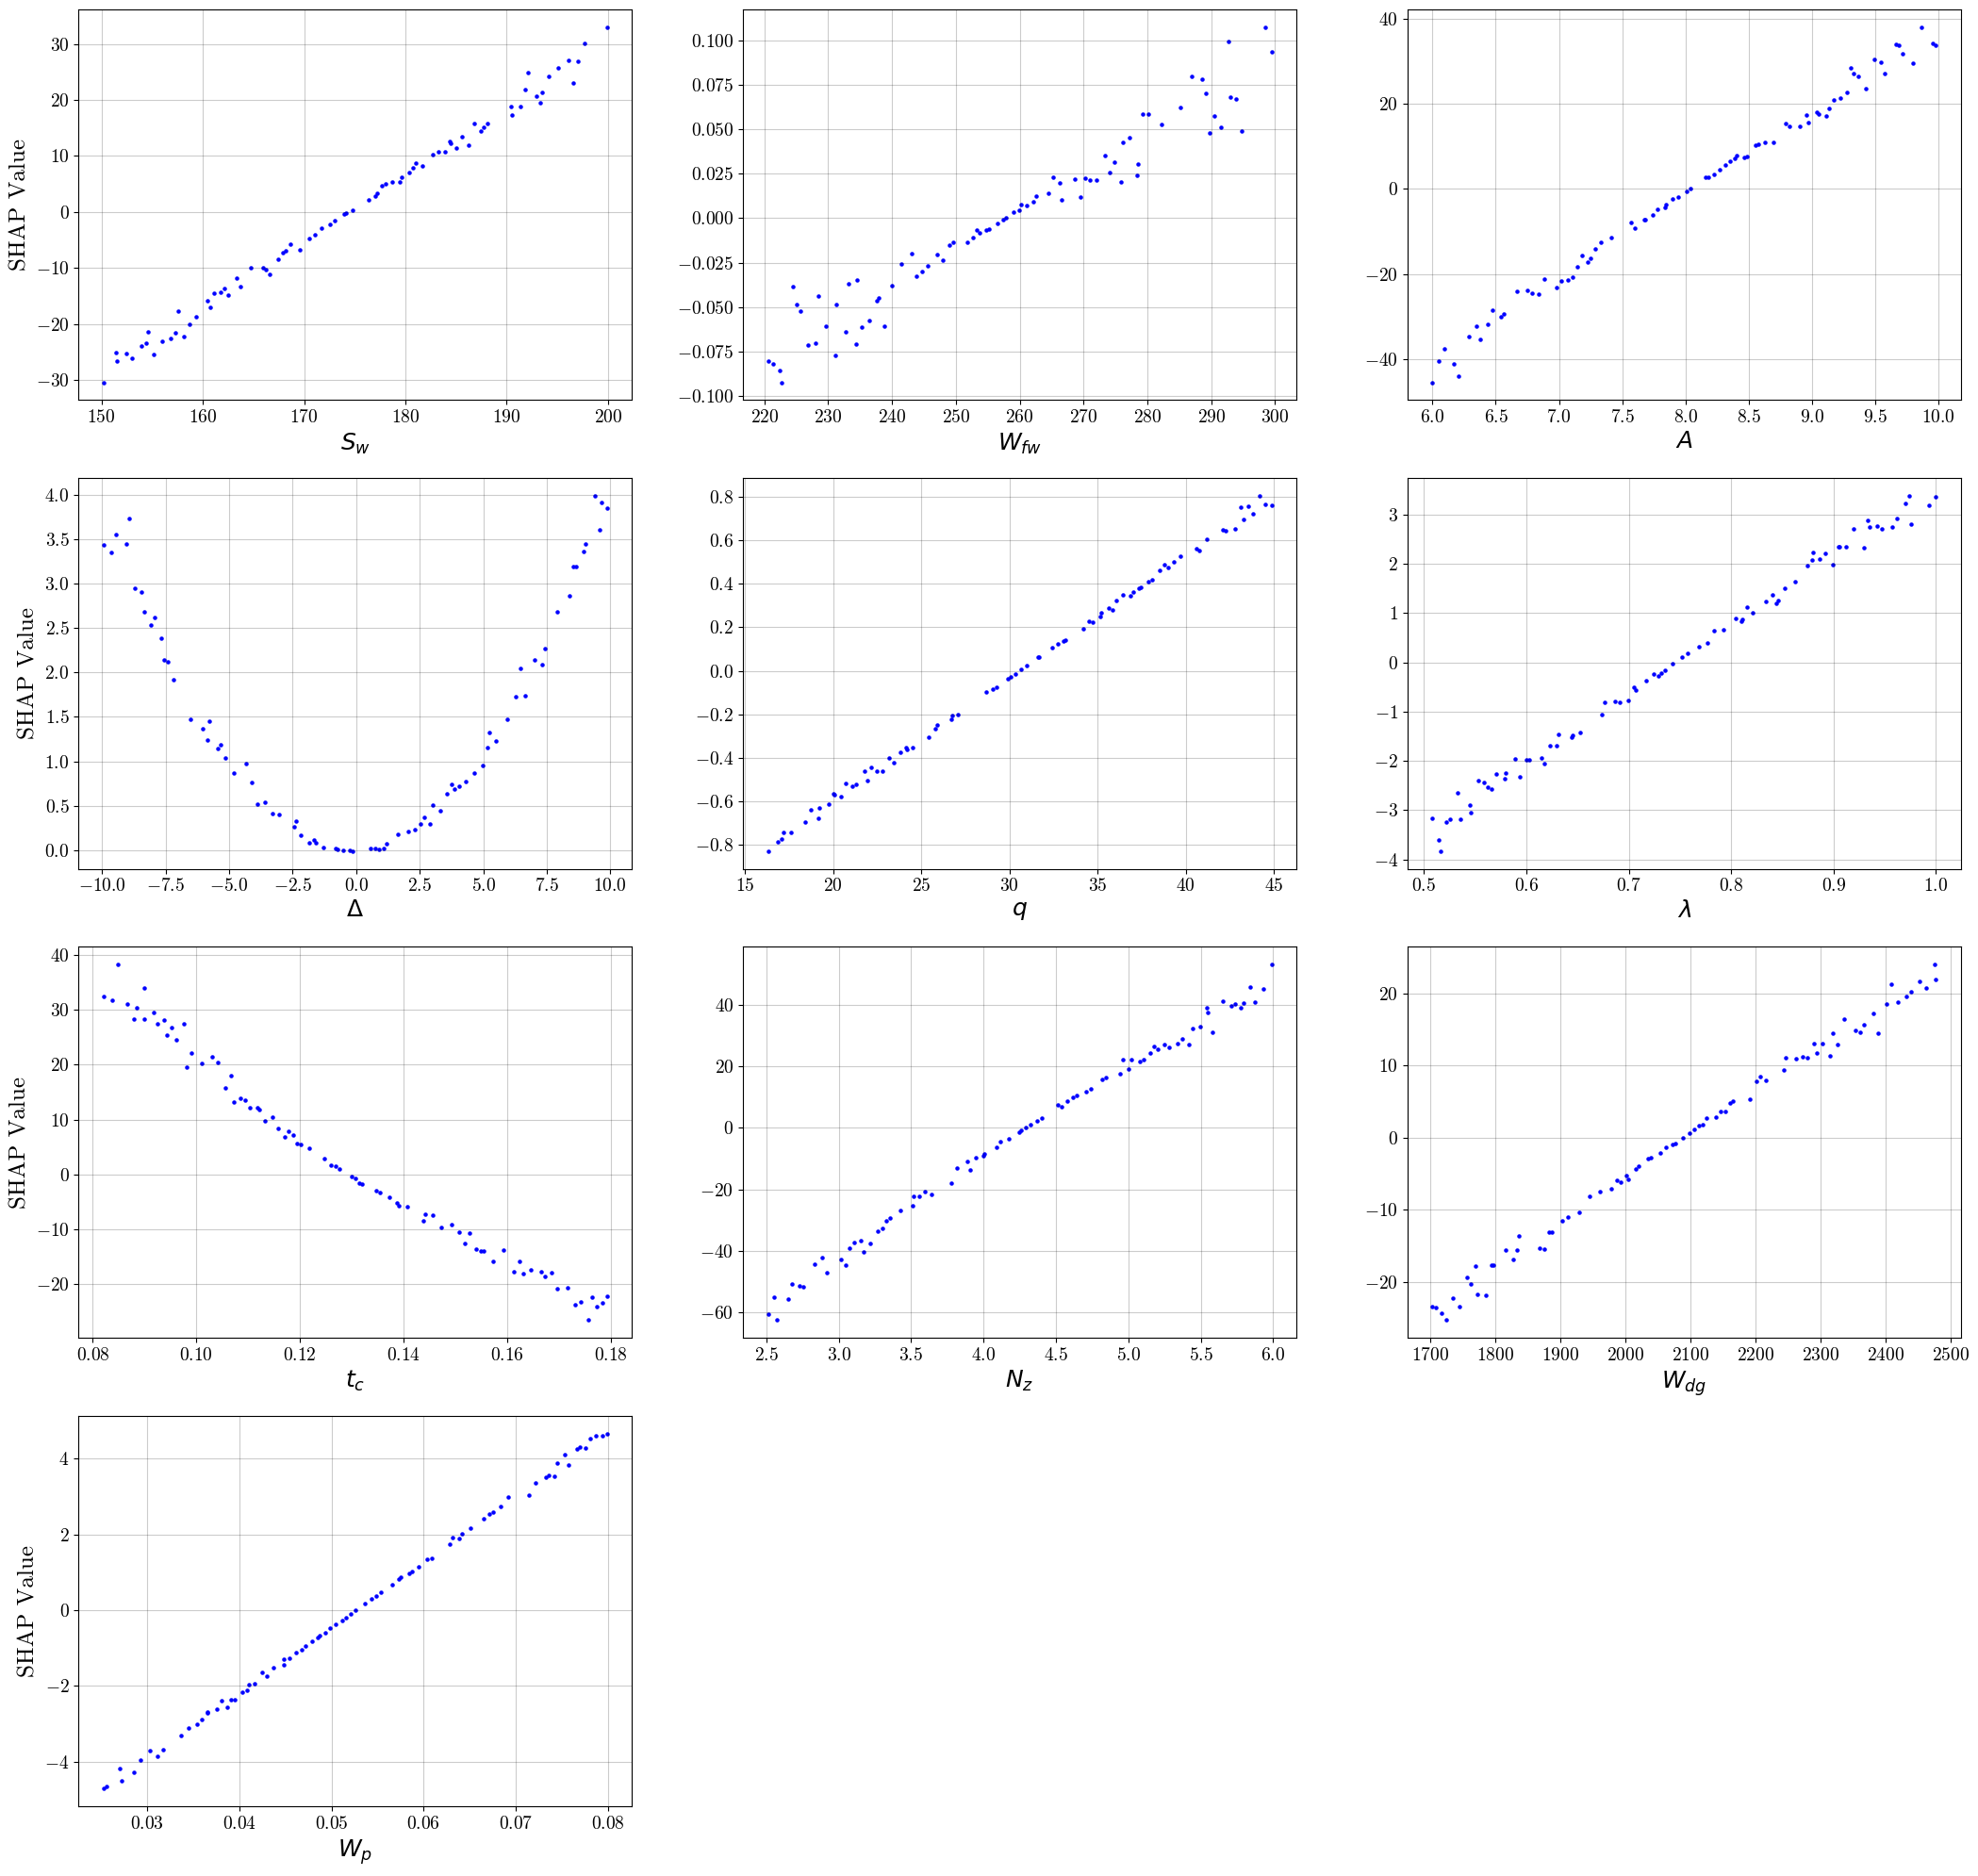

In [8]:
%%time
features = [i for i in range(X_tr.shape[1])]

exact_shap_dependence = exact_shap_explainer.dependence_plot(features)
exact_shap_dependence

In [10]:
kernel_shap_feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    sm, 
    X_tr, 
    feature_names=feature_names,
    method="kernel"
)

In [11]:
exact_shap_feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    sm, 
    X_tr, 
    feature_names=feature_names,
    method="exact",
)

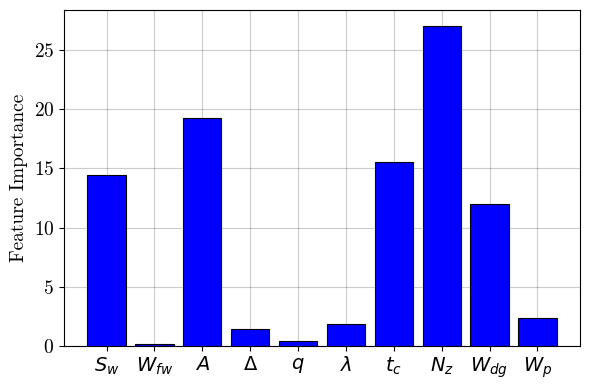

In [12]:
fig = kernel_shap_feature_importance.plot(sort=False)
fig

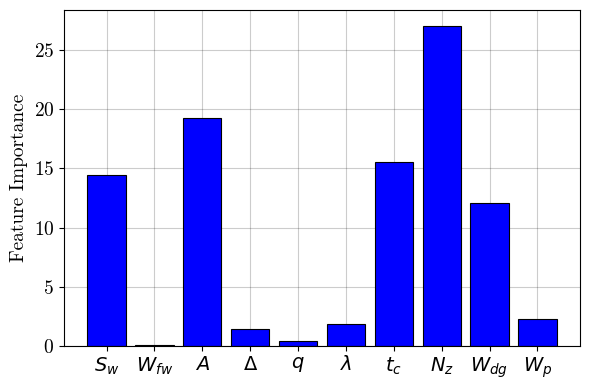

In [13]:
fig = exact_shap_feature_importance.plot(sort=False)
fig

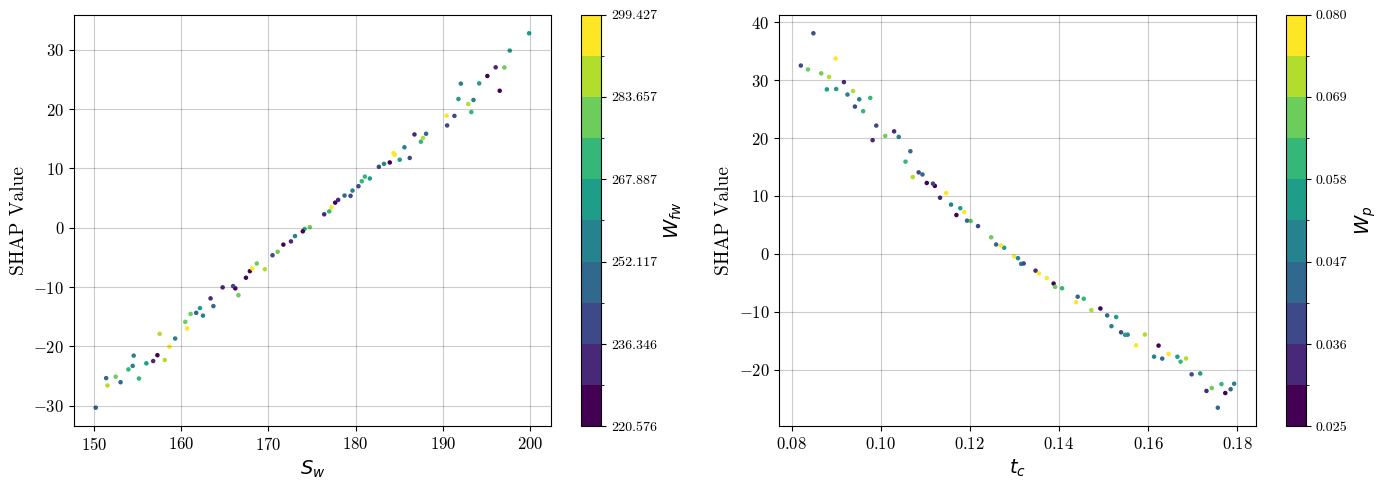

In [14]:
feature_pairs = [(0, 1), (6, 9)]

fig = kernel_shap_explainer.interaction_plot(feature_pairs)
fig

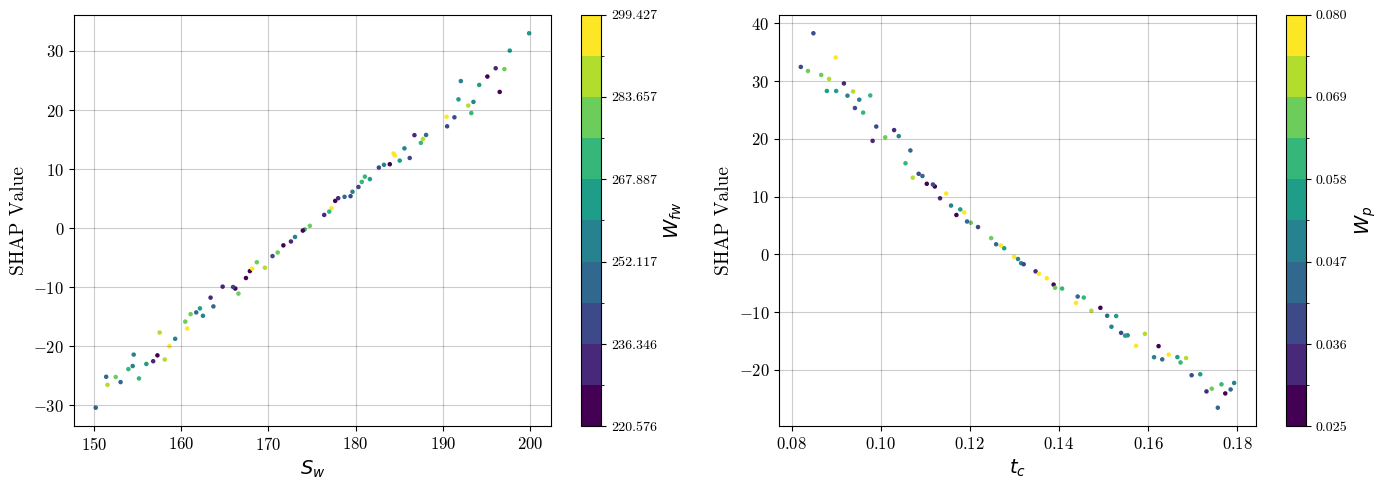

In [15]:
feature_pairs = [(0, 1), (6, 9)]

fig = exact_shap_explainer.interaction_plot(feature_pairs)
fig

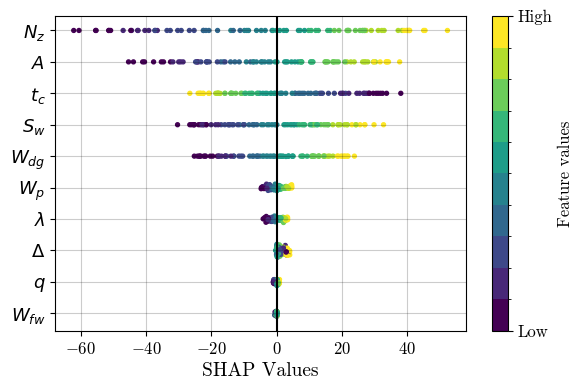

In [16]:
fig = kernel_shap_explainer.summary_plot()
fig

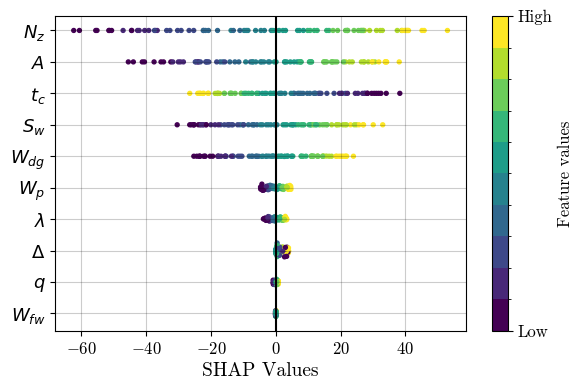

In [17]:
fig = exact_shap_explainer.summary_plot()
fig

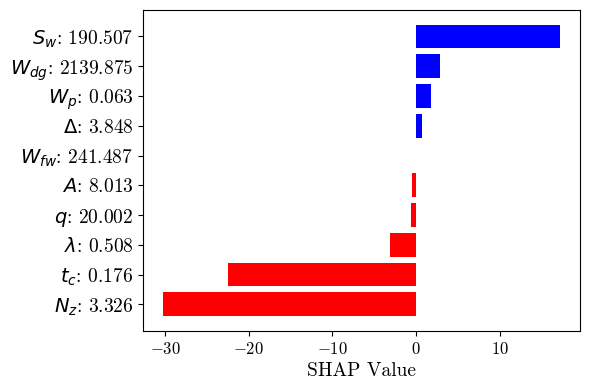

In [18]:
fig = kernel_shap_explainer.individual_plot(index=10)
fig

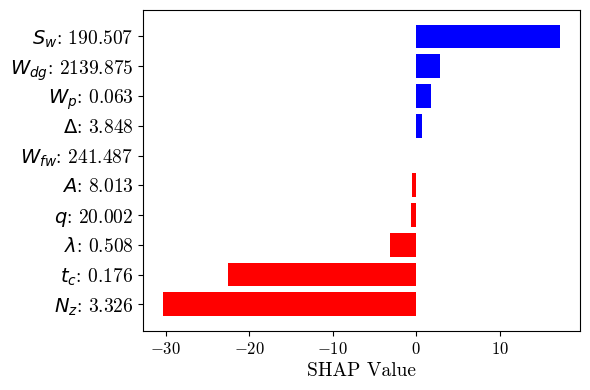

In [19]:
fig = exact_shap_explainer.individual_plot(index=10)
fig